In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

In [12]:
coca = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")

In [15]:
coca1 = coca.copy()

In [16]:
coca1.head().T

,0,1,2,3,4
Quarter,Q1_86,Q2_86,Q3_86,Q4_86,Q1_87
Sales,1734.827,2244.960999,2533.804993,2154.962997,1547.818996


In [17]:
coca1.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [18]:
coca1.dtypes

Quarter     object
Sales      float64
dtype: object

In [19]:
coca1.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [20]:
temp = coca1.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')

In [21]:
coca1['quater'] = pd.to_datetime(temp).dt.strftime('%b-%Y')

In [22]:
coca1.head()

,Quarter,Sales,quater
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [23]:
coca1 = coca1.drop(['Quarter'], axis=1)

In [24]:
coca1.reset_index(inplace=True)

In [25]:
coca1['quater'] = pd.to_datetime(coca1['quater'])

In [26]:
coca1 = coca1.set_index('quater')

In [27]:
coca1.head()

,index,Sales
quater,,
1986-01-01,0,1734.827000
1986-04-01,1,2244.960999
1986-07-01,2,2533.804993
1986-10-01,3,2154.962997
1987-01-01,4,1547.818996


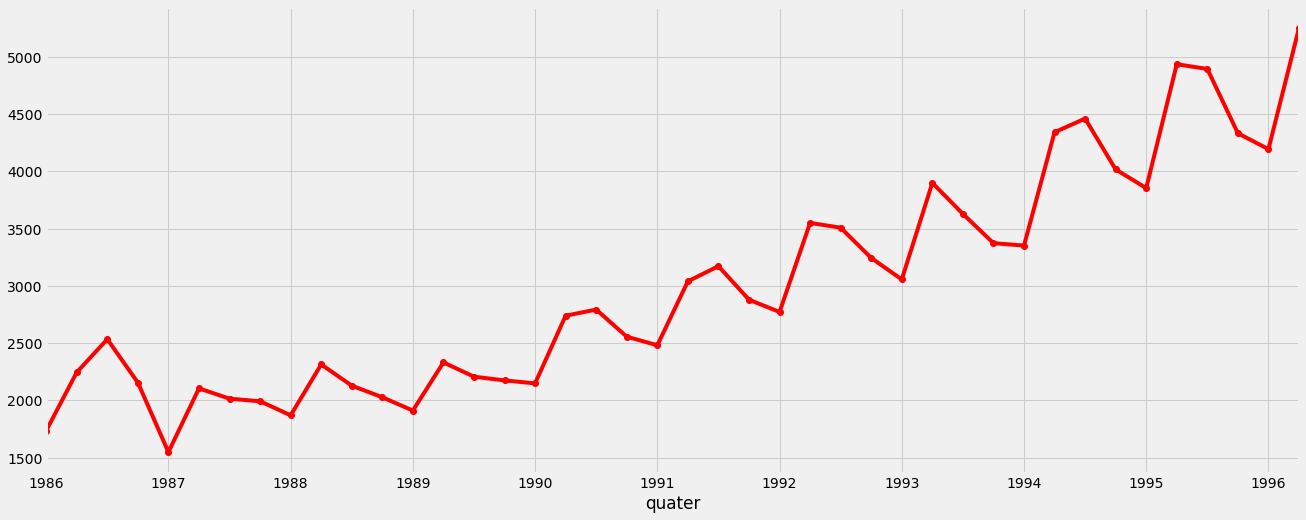

In [28]:
coca1['Sales'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

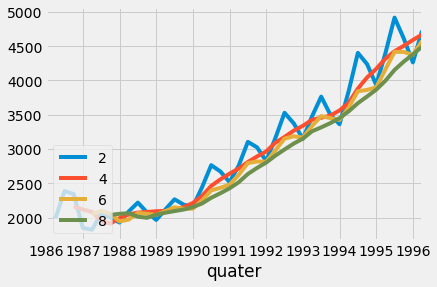

In [29]:
for i in range(2,10,2):
    coca1["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

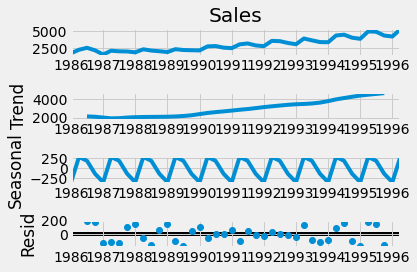

In [30]:
ts_add = seasonal_decompose(coca1.Sales,model="additive")
fig = ts_add.plot()
plt.show()

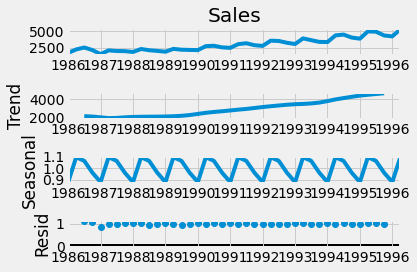

In [31]:
ts_mul = seasonal_decompose(coca1.Sales,model="multiplicative")
fig = ts_mul.plot()
plt.show()

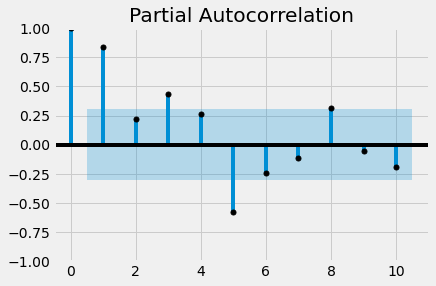

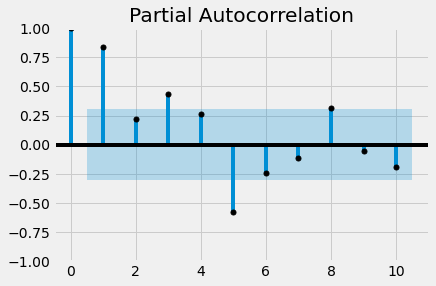

In [32]:
tsa_plots.plot_pacf(coca1.Sales, lags=10,color='black')

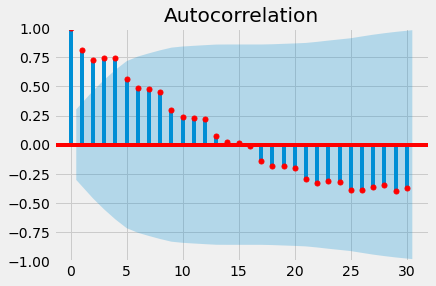

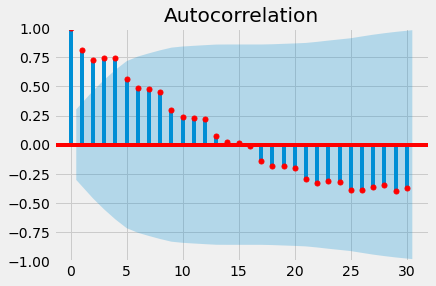

In [33]:
tsa_plots.plot_acf(coca1.Sales, lags=30,color='red')

## Building Time series forecasting with ARIMA

In [36]:
X = coca1['Sales'].values
size = int(len(X) * 0.66)

train, test = X[0:size], X[size:len(X)]

model = sm.tsa.arima.ARIMA(train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -174.082
Date:                Fri, 29 Jul 2022   AIC                            360.163
Time:                        21:54:53   BIC                            367.712
Sample:                             0   HQIC                           362.337
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1024      0.306     -0.335      0.738      -0.702       0.497
ar.L2         -0.2140      0.160     -1.338      0.181      -0.527       0.099
ar.L3         -0.0892      0.191     -0.468      0.6

# This summarizes the coefficient values used and the skill of the fit on the in-sample observations


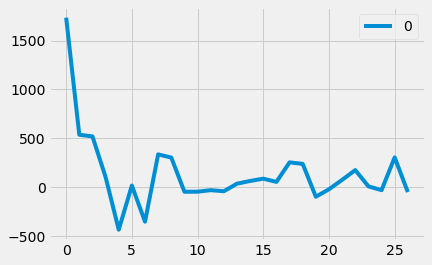

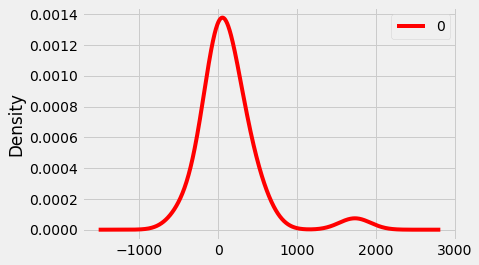

                 0
count    27.000000
mean    137.791853
std     385.970462
min    -433.659592
25%     -34.938861
50%      55.067401
75%     247.080157
max    1734.827000


In [37]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde',color='red')
pyplot.show()
print(residuals.describe())

#### Non 0 mean in the residuals suggest that there may still be a trend not captured by the model

### Rolling Forecast ARIMA Model

In [38]:
history = [x for x in train]
predictions = list()


In [40]:
for t in range(len(test)):
	model = sm.tsa.arima.ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=3130.132571, expected=3243.859993
predicted=3167.315970, expected=3056.000000
predicted=3717.472605, expected=3899.000000
predicted=3775.837490, expected=3629.000000
predicted=3332.735273, expected=3373.000000
predicted=3258.578857, expected=3352.000000
predicted=4081.006048, expected=4342.000000
predicted=3955.784520, expected=4461.000000
predicted=4146.277724, expected=4017.000000
predicted=3958.436380, expected=3854.000000
predicted=4701.652914, expected=4936.000000
predicted=4990.071214, expected=4895.000000
predicted=4390.352744, expected=4333.000000
predicted=4190.883766, expected=4194.000000
predicted=5177.071187, expected=5253.000000


In [41]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 34279.261


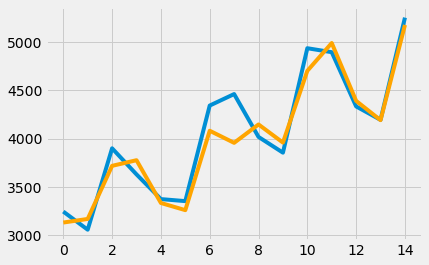

In [42]:
pyplot.plot(test)
pyplot.plot(predictions, color='orange')
pyplot.show()

#### Expected values in blue and forecast predictions in yellow are almost in a similar scale

In [43]:
# Comparing Multiple Models

coca2 = pd.get_dummies(coca, columns = ['Quarter'])
coca2.columns = ['Sales','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q1','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q2','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q3','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4','Q4']
coca2.head().T


,0,1,2,3,4
Sales,1734.827,2244.960999,2533.804993,2154.962997,1547.818996
Q1,1.000,0.000000,0.000000,0.000000,0.000000
Q1,0.000,0.000000,0.000000,0.000000,1.000000
Q1,0.000,0.000000,0.000000,0.000000,0.000000
Q1,0.000,0.000000,0.000000,0.000000,0.000000
Q1,0.000,0.000000,0.000000,0.000000,0.000000
Q1,0.000,0.000000,0.000000,0.000000,0.000000
Q1,0.000,0.000000,0.000000,0.000000,0.000000
Q1,0.000,0.000000,0.000000,0.000000,0.000000
Q1,0.000,0.000000,0.000000,0.000000,0.000000


In [44]:
t= np.arange(1,43)
coca2['t'] = t
coca2['t_sq'] = coca2['t']*coca2['t']
log_Sales=np.log(coca2['Sales'])
coca2['log_Sales']=log_Sales
coca2.head().T

,0,1,2,3,4
Sales,1734.827000,2244.960999,2533.804993,2154.962997,1547.818996
Q1,1.000000,0.000000,0.000000,0.000000,0.000000
Q1,0.000000,0.000000,0.000000,0.000000,1.000000
Q1,0.000000,0.000000,0.000000,0.000000,0.000000
Q1,0.000000,0.000000,0.000000,0.000000,0.000000
Q1,0.000000,0.000000,0.000000,0.000000,0.000000
Q1,0.000000,0.000000,0.000000,0.000000,0.000000
Q1,0.000000,0.000000,0.000000,0.000000,0.000000
Q1,0.000000,0.000000,0.000000,0.000000,0.000000
Q1,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
train1, test1 = np.split(coca2, [int(.67 *len(coca2))])

In [46]:
linear= smf.ols('Sales ~ t',data=train1).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test1['t'])))
rmselin=np.sqrt((np.mean(np.array(test1['Sales'])-np.array(predlin))**2))
rmselin

580.1224130918637

In [47]:
quad=smf.ols('Sales~t+t_sq',data=train1).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test1[['t','t_sq']])))
rmsequad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predquad))**2))
rmsequad

783.7297975037425

In [48]:
expo=smf.ols('log_Sales~t',data=train1).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test1['t'])))
rmseexpo=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

588.1405104900183

In [49]:
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train1).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmseadd=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predadd))**2))
rmseadd

1869.7188209186954

In [50]:
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmseaddlinear=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

596.1526282372528

In [51]:
addquad=smf.ols('Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test1[['t','t_sq','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(predaddquad))**2))
rmseaddquad

412.114443605461

In [52]:
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train1).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test1[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

2374.919440795444

In [53]:
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train1).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test1[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

5359.687911931751

In [54]:
mul_quad= smf.ols('log_Sales~t+t_sq+Q1+Q2+Q3+Q4',data=train1).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test1[['t','t_sq','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test1['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

3630.5619467352553

In [55]:
output = {'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),
          'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}

In [56]:
rmse=pd.DataFrame(output)

In [57]:
print(rmse)

           Model       Values
0  rmse_mul_quad  3630.561947
1        rmseadd  1869.718821
2  rmseaddlinear   596.152628
3    rmseaddquad   412.114444
4       rmseexpo   588.140510
5        rmselin   580.122413
6        rmsemul  2374.919441
7      rmsemulin  5359.687912
8       rmsequad   783.729798


In [ ]:
# Additive seasonality with quadratic trend has the best RMSE value